# **mRNA Subcellular Localization: k‑mer Feature Extraction & ML Classifications**

#### **Project CSI 5180. Topics in Artificial Intelligence: Machine Learning for Bioinformatics**

Steven Wilson (300220675)<br>
MASc in Biomedical Engineering<br>
University of Ottawa <br>


---



##### **Localization with k‑mer Features and ML Models**

This notebook reconstructs and cleans k‑mer (k=1–5) feature matrices from raw mRNA sequences, then trains and evaluates three classifiers: CatBoost, XGBoost, and LightGBM, to replicate and compare subcellular localization predictions from Musleh et al. (2024).


> Musleh, S., Arif, M., Alajez, N. M. & Alam, T. (2024). Unified mRNA Subcellular Localization Predictor based on machine learning techniques. BMC Genomics, 25(1), 151. https://doi.org/10.1186/s12864-024-10077-9

**Package Installation and Imports**

In [1]:
%pip install catboost biopython ipython-autotime lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00


In [ ]:
import os
import requests
import shap
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from itertools import product
from collections import Counter
from IPython.display import display
from io import StringIO
from Bio import SeqIO
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, classification_report, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression


# from utilities import Encode_Standarize, get_average_matrix, pretty_print_confusion_matrix, do_cross_validation, calculate_classification_report, draw_confusion_matrix

warnings.filterwarnings("ignore")

**Loading the Data**

In [ ]:
urls = {'sample_data_74': 'https://raw.githubusercontent.com/smusleh/UMSLP/refs/heads/main/src/Experiments/sample_dataset/SampleData746.csv',
        'dataset': 'https://raw.githubusercontent.com/smusleh/UMSLP/refs/heads/main/Data/Train/mRNALoc_5_loca_master_fasta_files_combined_Cyto_Endo_Ext_Mit_Nuc.fasta'}

def fetch_fasta_sequences(url: str) -> dict[str, str]:
    """
    Download a FASTA file from the given URL and parse it into a dict.
    """
    # Download
    resp = requests.get(url)
    resp.raise_for_status()

    # Parse
    fasta_io = StringIO(resp.text)
    return {rec.id: str(rec.seq) for rec in SeqIO.parse(fasta_io, "fasta")}


def fetch_sequence(url):
    """ Fetches sequences from a url and returns them as a panda"""
    response = requests.get(url)
    df = pd.read_csv(url)
    return df

seq_dict = fetch_fasta_sequences(urls['dataset'])
print(f"Found {len(seq_dict)} records")
print(seq_dict['mRNALoc_403#10320_Cytoplasm'][:60] + '…') # test


Found 12410 records
ATTGTGAAAGAAAGCTGGGAAGAGCTCCGCGGCCAAGTTAGCAGGACACTCTAACAAGTG…


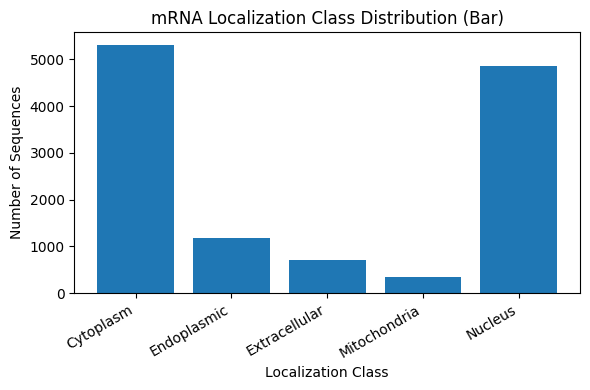

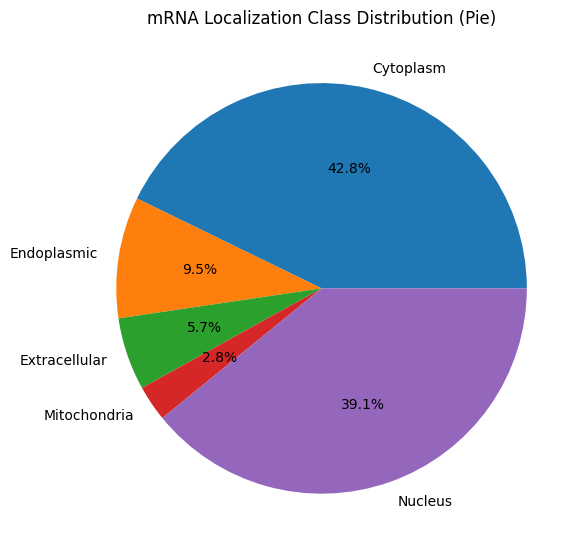

{'Cytoplasm': 5310, 'Endoplasmic': 1185, 'Extracellular': 710, 'Mitochondria': 350, 'Nucleus': 4855}


In [ ]:
def analyze_class_distribution(seq_dict: dict[str, str], plot: bool = True):
    """
    Count how many sequences belong to each localization class
    (assumes class is the substring after the last underscore in the record ID).
    If plot=True, shows both a bar chart and a pie chart.
    """
    # Extract class labels
    classes = [rid.rsplit('_', 1)[-1] for rid in seq_dict]

    # Count classes
    dist = Counter(classes)
    out = dict(dist)

    if plot:
        labels, counts = zip(*sorted(dist.items()))

        # --- Bar chart ---
        plt.figure(figsize=(6, 4))
        plt.bar(labels, counts)
        plt.xlabel("Localization Class")
        plt.ylabel("Number of Sequences")
        plt.title("mRNA Localization Class Distribution (Bar)")
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()

        # --- Pie chart ---
        plt.figure(figsize=(6, 6))
        plt.pie(counts, labels=labels, autopct='%1.1f%%')
        plt.title("mRNA Localization Class Distribution (Pie)")
        plt.tight_layout()
        plt.show()

    return out

dist = analyze_class_distribution(seq_dict)
print(dist)

**Data Encoding (K-mer)**

In [ ]:
def extract_kmer_features(seq_dict: dict[str, str],ks: list[int] = (2, 3, 4, 5)):
    """
    Turn each sequence into a 1360‑dim feature vector of normalized k‑mer counts.

    Parameters
    seq_dict : dict
        Mapping from record ID to nucleotide sequence (uppercase, no gaps).
    ks : list of int
        List of k values to consider (default [2,3,4,5]).

    Returns
    pd.DataFrame
        Rows = sequence IDs, columns = all possible k‑mers sorted.
        Values = count(kmer) / (num_windows) / (4**k)
    """

    # Build list of all feature names, ['AA','TTT','AAAAA',...]
    all_kmers = []
    for k in ks:
        all_kmers.extend(''.join(p) for p in product('ACGT', repeat=k))

    # for each sequence, count + normalize
    rows = []
    for rid, seq in seq_dict.items():
        feats = []
        for k in ks:
            window_count = max(len(seq) - k + 1, 1)
            # raw counts of each k-mer in this seq
            raw = Counter(
                seq[i:i+k]
                for i in range(len(seq) - k + 1)
                if set(seq[i:i+k]) <= {'A','C','G','T'}  # skip those who are not ACGT
            )
            # for each possible k-mer, append normalized value
            for kmer in product('ACGT', repeat=k):
                key = ''.join(kmer)
                # freq = count / windows, then adjust for possible combos
                val = raw.get(key, 0) / window_count / (4**k)
                feats.append(val)
        rows.append((rid, feats))

    # build df
    index, data = zip(*rows)
    df = pd.DataFrame(data, index=index, columns=all_kmers)
    return df

features_df = extract_kmer_features(seq_dict)
print(features_df.shape)
features_df.head()

(12410, 1360)


,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
mRNALoc_403#10320_Cytoplasm,0.004938,0.003295,0.004532,0.003731,0.004750,0.004522,0.001910,0.004176,0.004057,0.003820,...,0.000000e+00,2.629742e-06,2.010979e-06,1.082835e-06,1.082835e-06,2.475051e-06,1.546907e-06,0.000002,3.093814e-06,3.557887e-06
mRNALoc_4404#20399_Cytoplasm,0.002638,0.002511,0.005368,0.001874,0.004185,0.007314,0.002311,0.004913,0.004221,0.004749,...,5.690924e-07,2.845462e-07,5.690924e-07,2.845462e-07,0.000000e+00,1.138185e-06,2.845462e-07,0.000001,5.690924e-07,2.845462e-07
mRNALoc_3392#17196_Cytoplasm,0.003347,0.003576,0.005006,0.002546,0.004834,0.006093,0.002231,0.004720,0.004262,0.004319,...,8.951077e-07,1.342662e-06,8.951077e-07,4.475538e-07,4.475538e-07,8.951077e-07,8.951077e-07,0.000003,4.475538e-07,4.475538e-07
mRNALoc_3095#162989_Cytoplasm,0.001976,0.003119,0.004632,0.001698,0.004508,0.006299,0.003181,0.005497,0.003767,0.006639,...,0.000000e+00,4.832076e-07,9.664151e-07,0.000000e+00,1.449623e-06,4.832076e-07,4.832076e-07,0.000000,0.000000e+00,0.000000e+00
mRNALoc_1488#117177_Cytoplasm,0.006865,0.003187,0.004547,0.004747,0.004281,0.002636,0.000764,0.003977,0.004165,0.002610,...,3.036890e-07,1.720904e-06,1.923363e-06,9.110669e-07,2.530741e-06,1.923363e-06,2.631971e-06,0.000002,2.429512e-06,3.644268e-06


**Classification Models**


=== CatBoost (5‑fold CV on TRAIN) ===
accuracy        : 0.7870 ± 0.0041
precision_macro : 0.8718 ± 0.0125
recall_macro    : 0.6397 ± 0.0094
f1_macro        : 0.6789 ± 0.0115


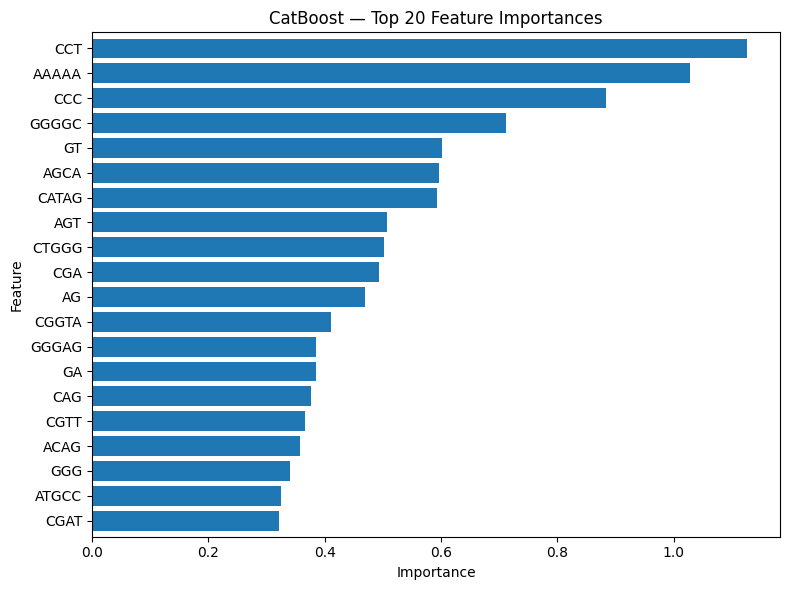


>>> Fitting CatBoost on full TRAIN and evaluating on TEST:
               precision    recall  f1-score   support

    Cytoplasm     0.7717    0.8879    0.8257      1062
  Endoplasmic     0.9573    0.4726    0.6328       237
Extracellular     1.0000    0.1620    0.2788       142
 Mitochondria     1.0000    0.9286    0.9630        70
      Nucleus     0.8142    0.8847    0.8480       971

     accuracy                         0.8066      2482
    macro avg     0.9086    0.6671    0.7096      2482
 weighted avg     0.8255    0.8066    0.7886      2482



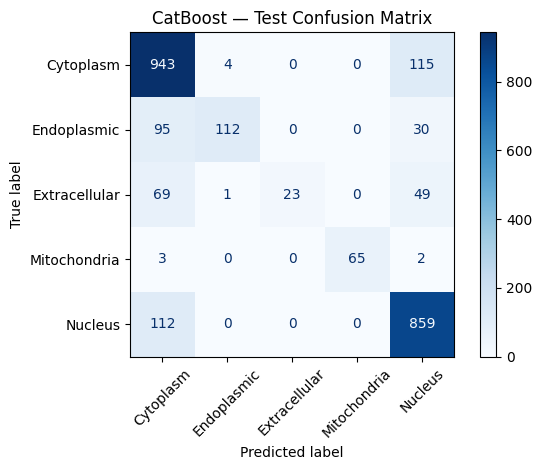


=== XGBoost (5‑fold CV on TRAIN) ===
accuracy        : 0.7841 ± 0.0057
precision_macro : 0.8654 ± 0.0150
recall_macro    : 0.6351 ± 0.0159
f1_macro        : 0.6764 ± 0.0174


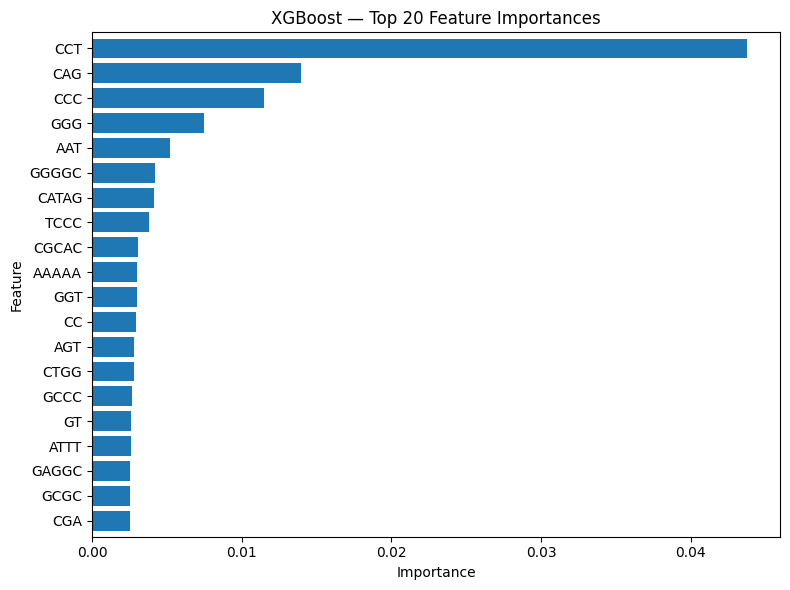


>>> Fitting XGBoost on full TRAIN and evaluating on TEST:
               precision    recall  f1-score   support

    Cytoplasm     0.7796    0.8927    0.8323      1062
  Endoplasmic     0.9328    0.4684    0.6236       237
Extracellular     1.0000    0.1690    0.2892       142
 Mitochondria     1.0000    0.9571    0.9781        70
      Nucleus     0.8172    0.8888    0.8515       971

     accuracy                         0.8110      2482
    macro avg     0.9059    0.6752    0.7149      2482
 weighted avg     0.8278    0.8110    0.7929      2482



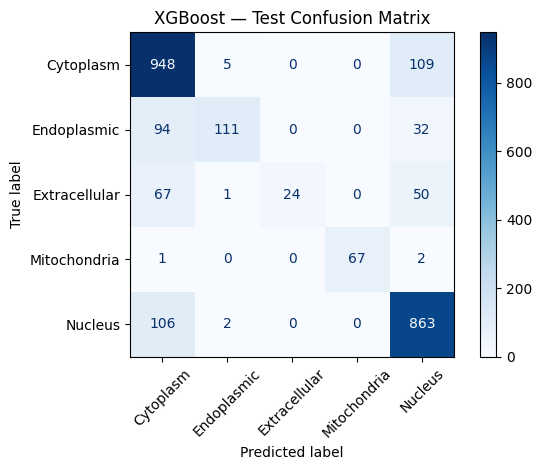


=== LightGBM (5‑fold CV on TRAIN) ===
accuracy        : 0.8004 ± 0.0032
precision_macro : 0.8779 ± 0.0123
recall_macro    : 0.6567 ± 0.0078
f1_macro        : 0.7002 ± 0.0102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346800
[LightGBM] [Info] Number of data points in the train set: 9928, number of used features: 1360
[LightGBM] [Info] Start training from score -0.848911
[LightGBM] [Info] Start training from score -2.348760
[LightGBM] [Info] Start training from score -2.860993
[LightGBM] [Info] Start training from score -3.568325
[LightGBM] [Info] Start training from score -0.938493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

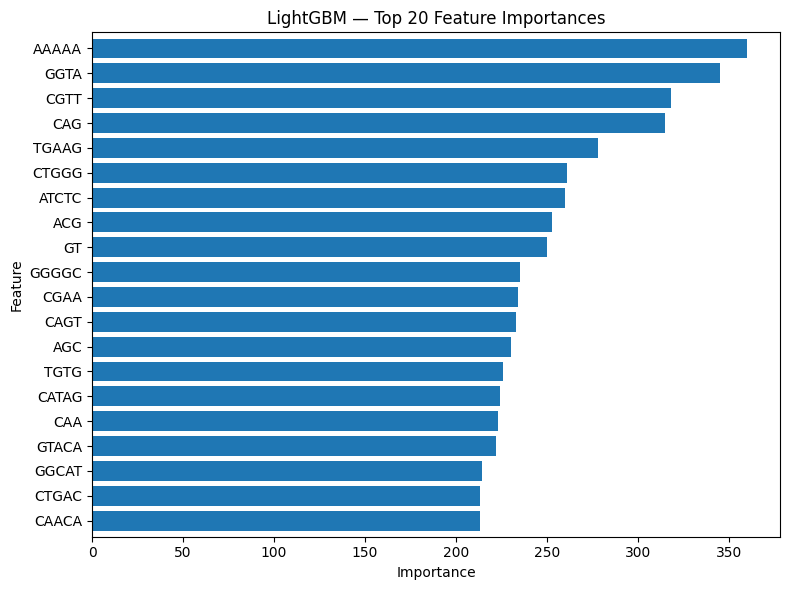


>>> Fitting LightGBM on full TRAIN and evaluating on TEST:
               precision    recall  f1-score   support

    Cytoplasm     0.7961    0.8898    0.8404      1062
  Endoplasmic     0.9302    0.5063    0.6557       237
Extracellular     1.0000    0.2042    0.3392       142
 Mitochondria     1.0000    0.9429    0.9706        70
      Nucleus     0.8189    0.9032    0.8590       971

     accuracy                         0.8207      2482
    macro avg     0.9090    0.6893    0.7330      2482
 weighted avg     0.8352    0.8207    0.8050      2482



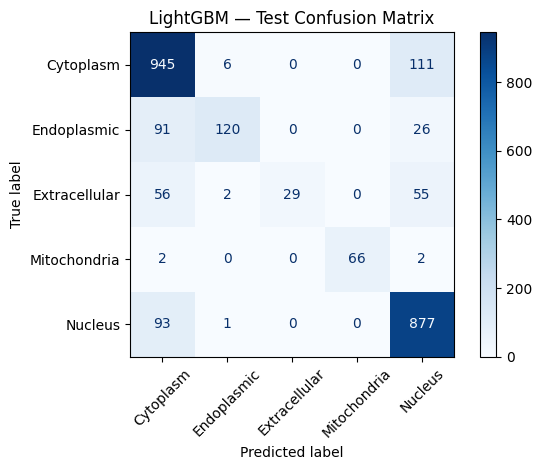

In [ ]:
# labels and train/test split
raw_labels = pd.Series([rid.rsplit('_',1)[-1] for rid in features_df.index], index=features_df.index, name="localization")

le = LabelEncoder()
y_all = le.fit_transform(raw_labels)

X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    features_df,
    y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42
)

# -- Classifiers --
catboost_gpu = CatBoostClassifier(
    iterations=1000, depth=6, learning_rate=0.1,
    task_type="GPU", devices='0', verbose=False,
    random_seed=42
)

xgboost_gpu = XGBClassifier(
    tree_method='gpu_hist', predictor='gpu_predictor',
    gpu_id=0, verbosity=1, seed=42
)

lgbm = lgb.LGBMClassifier(
    n_estimators=1000, learning_rate=0.05,
    num_leaves=31, random_state=42
)

classifier_name = ['CatBoost', 'XGBoost', 'LightGBM']
classifiers     = [catboost_gpu, xgboost_gpu, lgbm]

# Stratified K‑Fold and scoring
skf     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for name, clf in zip(classifier_name, classifiers):
    print(f"\n=== {name} (5‑fold CV on TRAIN) ===")
    cv_results = cross_validate(
        clf, X_train, y_train_enc,
        cv=skf, scoring=scoring, n_jobs=-1
    )
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric:16s}: {scores.mean():.4f} ± {scores.std():.4f}")

    # final fit on full TRAIN
    clf.fit(X_train, y_train_enc)

    # feature importances
    importances = clf.feature_importances_

    # series and select the top 20
    feat_imp = pd.Series(importances, index=X_train.columns)
    top20   = feat_imp.nlargest(20).sort_values()

    # Plot horizontal bar chart
    plt.figure(figsize=(8,6))
    top20.plot(kind='barh', width=0.8)
    plt.title(f"{name} — Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print(f"\n>>> Fitting {name} on full TRAIN and evaluating on TEST:")
    # predictions on TEST
    y_pred_enc = clf.predict(X_test)
    y_pred     = le.inverse_transform(y_pred_enc)
    y_test     = le.inverse_transform(y_test_enc)

    # classification report
    print(classification_report(
        y_test, y_pred,
        labels=le.classes_,
        target_names=le.classes_,
        digits=4
    ))

    # confusion matrix
    cm   = confusion_matrix(y_test, y_pred, labels=le.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{name} — Test Confusion Matrix")
    plt.tight_layout()
    plt.show()